# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [91]:
%load_ext autoreload
%autoreload 2
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
from helpers import compute_epsilon_change, choose_action, get_best_action, get_epsilon_greedy_action_probabilities
%matplotlib inline

import check_test
from plot_utils import plot_values

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [34]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [35]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

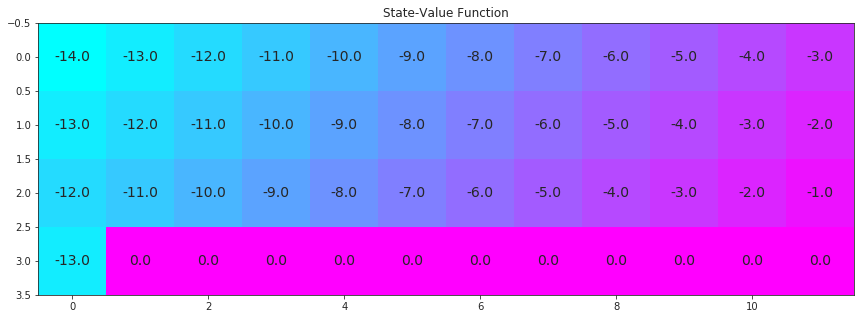

In [36]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [71]:
def sarsa(env, num_episodes, alpha, gamma=1.0, starting_epsilon = 1, finishing_epsilon = 0.1):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon
    epsilon_change = compute_epsilon_change(episode_count=num_episodes, starting_epsilon=starting_epsilon, finishing_epsilon=finishing_epsilon)
    epsilon = starting_epsilon
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1 == 0:
            print("\rEpisode: {}/{}, Epsilon: {}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   

        # Episode loop
        done = False
        state = env.reset()
        previous_state = previous_action = previous_reward = None
        while not done:
            action = choose_action(q_table=Q, state=state, number_of_actions=env.nA, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)
            
            # Special case where we don't have enough data to update on first step.
            if previous_state != None:
                previous_value = Q[previous_state][previous_action]
                current_value = Q[state][action]
                Q[previous_state][previous_action] += alpha*(previous_reward + gamma*current_value - previous_value)
                
            [previous_state, previous_action, previous_reward] = [state,action,reward]
            state = next_state
        epsilon -= epsilon_change
        
    print("\nFinal Epsilon:",epsilon)
    print("\nQ:", Q)

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode: 5000/5000, Epsilon: 0.0
Final Epsilon: 0.0

Q: defaultdict(<function sarsa.<locals>.<lambda> at 0x7f9828343620>, {36: array([-11.9999997 , -13.93010417, -12.00987703, -12.01336963]), 24: array([-11.00215542, -10.99999993, -11.01611931, -11.01399567]), 12: array([-10.27684089, -10.27317424, -10.27452798, -10.28031429]), 0: array([-9.84166309, -9.8408016 , -9.84025577, -9.84664235]), 1: array([-9.36383154, -9.3653712 , -9.36312876, -9.36846225]), 2: array([-8.72565937, -8.72655403, -8.7283103 , -8.73962339]), 3: array([-8.02811284, -8.01676224, -8.02193328, -8.01929561]), 4: array([-7.27123759, -7.26892746, -7.26864638, -7.2716004 ]), 5: array([-6.49408466, -6.49386109, -6.50255446, -6.50430082]), 6: array([-5.71623055, -5.7077011 , -5.70940317, -5.70825691]), 7: array([-4.91886931, -4.91078552, -4.91544583, -4.92466857]), 8: array([-4.1229663 , -4.11619422, -4.1168255 , -4.11564409]), 9: array([-3.32730545, -3.32792342, -3.32788259, -3.34034628]), 10: array([-2.56980623, -2.559

**<span style="color: green;">PASSED</span>**

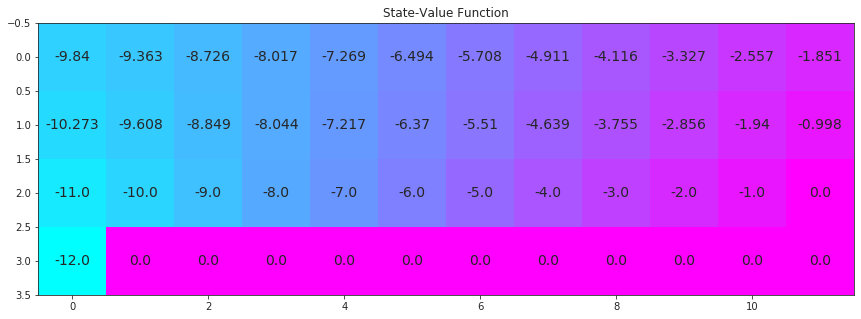

In [79]:
# obtain the estimated optimal policy and corresponding action-value function
# Note: as there are no positive rewards, greedy acton selection is actually better than any random exploration.
Q_sarsa = sarsa(env, 5000, .01, starting_epsilon=0, finishing_epsilon=0)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)


### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [83]:
def q_learning(env, num_episodes, alpha, gamma=1.0, starting_epsilon = 1, finishing_epsilon = 0.1):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon
    epsilon_change = compute_epsilon_change(episode_count=num_episodes, starting_epsilon=starting_epsilon, finishing_epsilon=finishing_epsilon)
    epsilon = starting_epsilon
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1 == 0:
            print("\rEpisode: {}/{}, Epsilon: {}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   

        # Episode loop
        done = False
        state = env.reset()
        previous_state = previous_action = previous_reward = None
        while not done:
            action = choose_action(q_table=Q, state=state, number_of_actions=env.nA, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)
            
            # Special case where we don't have enough data to update on first step.
            if previous_state != None:
                previous_value = Q[previous_state][previous_action]
                best_action = get_best_action(q_table=Q, state=state)
                best_action_value = Q[state][best_action]
                Q[previous_state][previous_action] += alpha*(previous_reward + gamma*best_action_value - previous_value)
                
            [previous_state, previous_action, previous_reward] = [state,action,reward]
            state = next_state
        epsilon -= epsilon_change
        
    print("\nFinal Epsilon:",epsilon)
    print("\nQ:", Q)

    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode: 5000/5000, Epsilon: 0.0
Final Epsilon: 0.0

Q: defaultdict(<function q_learning.<locals>.<lambda> at 0x7f98291d1b70>, {36: array([-11.9999997 , -13.93010417, -12.00987703, -12.01336963]), 24: array([-11.00215542, -10.99999993, -11.01611931, -11.01399567]), 12: array([-10.27684089, -10.27317424, -10.27452798, -10.28031429]), 0: array([-9.84166309, -9.8408016 , -9.84025577, -9.84664235]), 1: array([-9.36383154, -9.3653712 , -9.36312876, -9.36846225]), 2: array([-8.72565937, -8.72655403, -8.7283103 , -8.73962339]), 3: array([-8.02811284, -8.01676224, -8.02193328, -8.01929561]), 4: array([-7.27123759, -7.26892746, -7.26864638, -7.2716004 ]), 5: array([-6.49408466, -6.49386109, -6.50255446, -6.50430082]), 6: array([-5.71623055, -5.7077011 , -5.70940317, -5.70825691]), 7: array([-4.91886931, -4.91078552, -4.91544583, -4.92466857]), 8: array([-4.1229663 , -4.11619422, -4.1168255 , -4.11564409]), 9: array([-3.32730545, -3.32792342, -3.32788259, -3.34034628]), 10: array([-2.56980623, -

**<span style="color: green;">PASSED</span>**

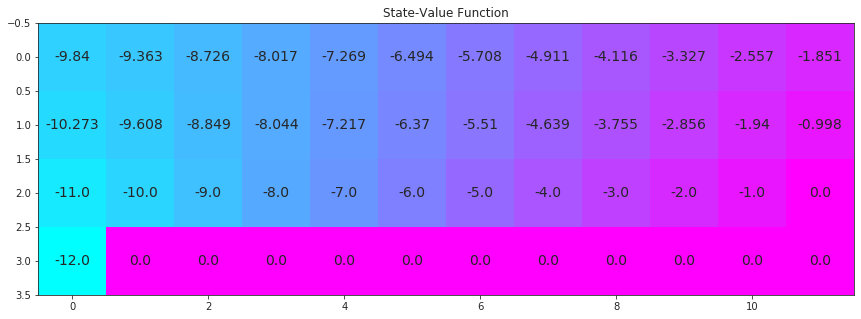

In [88]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01, starting_epsilon=0, finishing_epsilon=0)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])


### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [95]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, starting_epsilon = 1, finishing_epsilon = 0.1):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize epsilon
    epsilon_change = compute_epsilon_change(episode_count=num_episodes, starting_epsilon=starting_epsilon, finishing_epsilon=finishing_epsilon)
    epsilon = starting_epsilon
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1 == 0:
            print("\rEpisode: {}/{}, Epsilon: {}".format(i_episode, num_episodes, epsilon), end="")
            sys.stdout.flush()   

        # Episode loop
        done = False
        state = env.reset()
        previous_state = previous_action = previous_reward = None
        while not done:
            action = choose_action(q_table=Q, state=state, number_of_actions=env.nA, epsilon=epsilon)
            next_state, reward, done, info = env.step(action)
            
            # Special case where we don't have enough data to update on first step.
            if previous_state != None:
                previous_value = Q[previous_state][previous_action]
                probabilities = get_epsilon_greedy_action_probabilities(q_table=Q, state=state, number_of_actions=env.nA, epsilon=epsilon)
                expected_action_value = np.dot(probabilities, Q[state])
                Q[previous_state][previous_action] += alpha*(previous_reward + gamma*expected_action_value - previous_value)
                
            [previous_state, previous_action, previous_reward] = [state,action,reward]
            state = next_state
        epsilon -= epsilon_change
        
    print("\nFinal Epsilon:",epsilon)
    print("\nQ:", Q)

    return Q



Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode: 1000/1000, Epsilon: 0.0
Final Epsilon: 0.0

Q: defaultdict(<function expected_sarsa.<locals>.<lambda> at 0x7f9822b2b2f0>, {36: array([ -12., -100.,  -13.,  -12.]), 24: array([-12., -11., -12., -12.]), 12: array([-11., -11., -11., -12.]), 0: array([-12., -11., -12., -12.]), 1: array([-11., -11., -11., -10.]), 2: array([-11., -11., -11., -10.]), 3: array([-11., -10., -10., -10.]), 4: array([-10.,  -9.,  -9., -10.]), 5: array([-9., -8., -8., -8.]), 6: array([-8., -7., -7., -8.]), 7: array([-7., -6., -6., -6.]), 8: array([-6., -5., -5., -6.]), 9: array([-5., -4., -4., -4.]), 10: array([-4., -3., -3., -4.]), 11: array([-3., -3., -2., -2.]), 23: array([-2., -2., -1., -1.]), 22: array([-3., -2., -2., -3.]), 21: array([-4., -3., -3., -3.]), 20: array([-5., -4., -4., -5.]), 19: array([-6., -5., -5., -5.]), 18: array([-7., -6., -6., -7.]), 17: array([-8., -7., -7., -7.]), 16: array([-9., -8., -8., -9.]), 15: array([-10.,  -9.,  -9.,  -9.]), 14: array([-11., -10., -10., -11.]), 13: array

**<span style="color: green;">PASSED</span>**

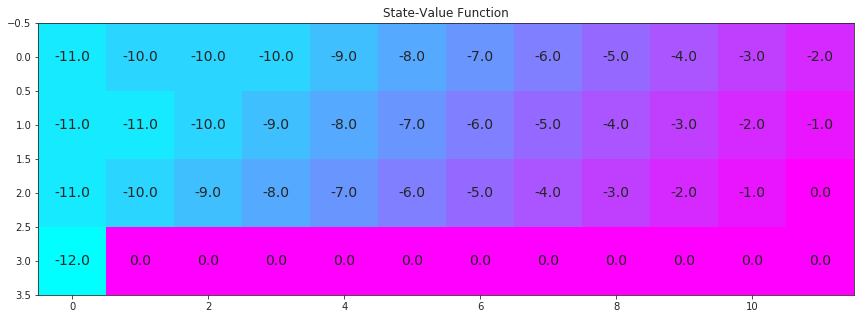

In [105]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 1000, 1, starting_epsilon=0, finishing_epsilon=0)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])
